In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# get list of frames from video.
# videopath - path to video
# verbose - 0 or 1 - report about work.

def get_list_of_frames(videopath, verbose=0):
    name = videopath

    cap = cv2.VideoCapture(name)

    fps = cap.get(cv2.CAP_PROP_FPS)

    frames = []

    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frames.append(frame)
    while ret:
        ret, frame = cap.read()
        # print ('Read a new frame: ', ret)
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            frames.append(frame)
    if (verbose > 0):
        print("Number of frames: {}".format(len(frames)))
        print("FPS: {}".format(fps))
    return frames, fps

In [3]:
# make video from list of frames

def create_video_from_frames(frames, fps):
    height , width =  frames[0].shape

    fourcc = -1

    video = cv2.VideoWriter('video.mp4', fourcc, fps, (width,height))

    for x in frames:
        video.write(x)
    
    video.release()

In [4]:
# Take first two captures and concatenate them to see a difference

name = "vid2.mp4"

cap = cv2.VideoCapture(name)

_, frame1 = cap.read()
_, frame2 = cap.read()

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)



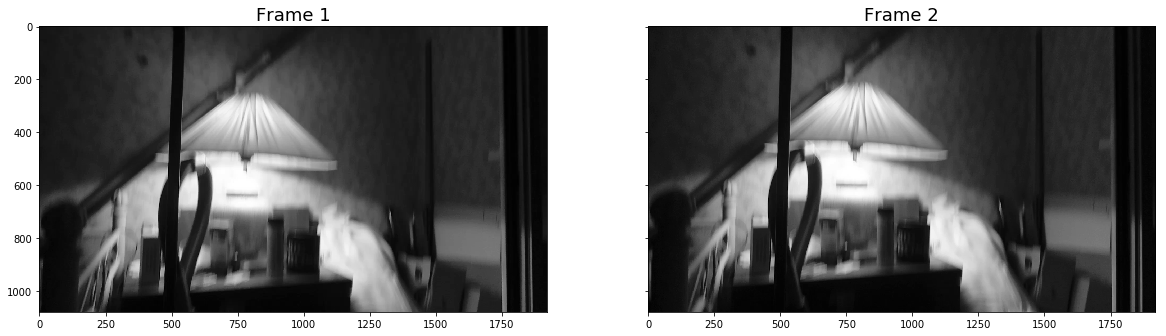

In [5]:
# print 2 frames

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(20, 40)
ax1.imshow(frame1, cmap='gray')
ax1.set_title("Frame 1", fontsize=18)
ax2.imshow(frame2, cmap='gray')
ax2.set_title("Frame 2", fontsize=18)
plt.show()

158


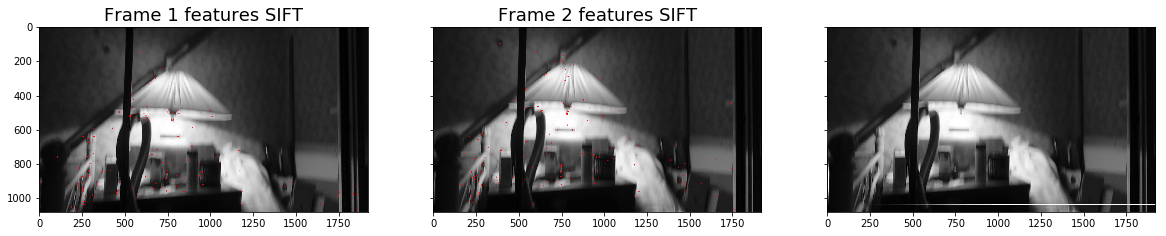

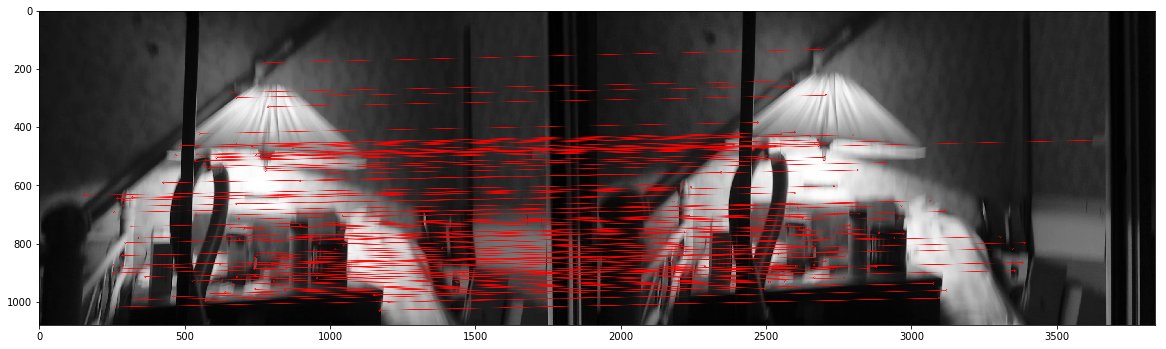

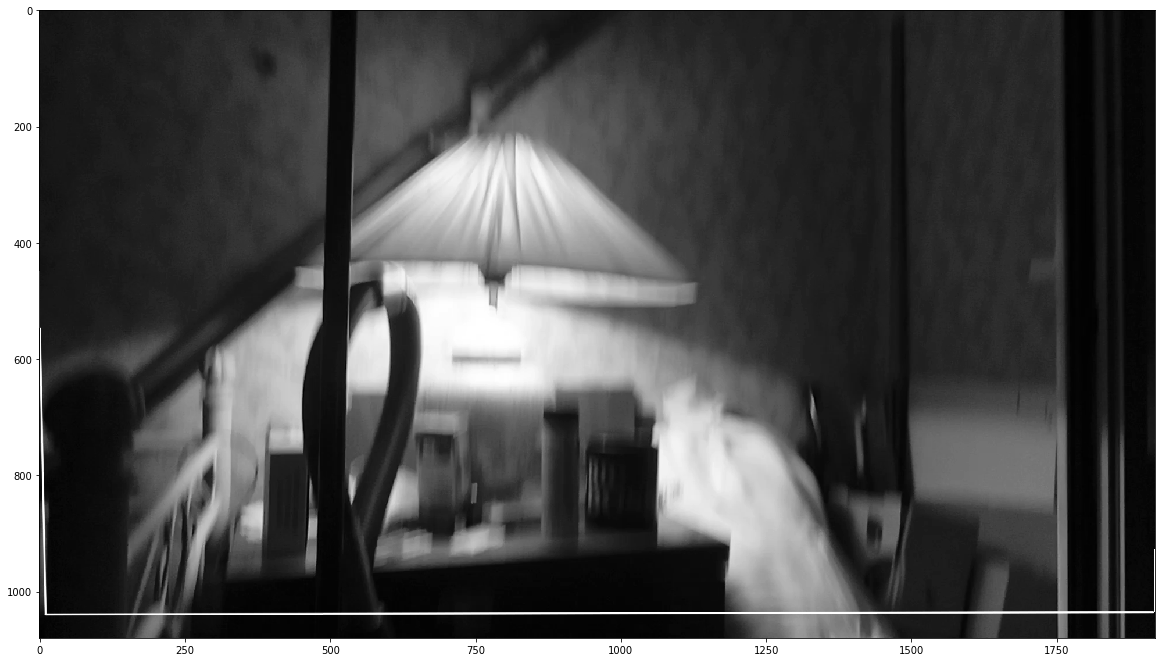

In [7]:
# detecting SIFT 
name = "vid2.mp4"

cap = cv2.VideoCapture(name)

_, frame1 = cap.read()
_, frame2 = cap.read()

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)



# detecting features, getting key points and descriptors for 2 frames
sift = cv2.xfeatures2d.SIFT_create()
key_points1, descriptors1 = sift.detectAndCompute(frame1, None)
key_points2, descriptors2 = sift.detectAndCompute(frame2, None)

features_1_show = frame1.copy()
features_2_show = frame2.copy()

# drawing of kps on each frame
features_1_show = cv2.drawKeypoints(frame1, key_points1, None, color=(255,0,0))
features_2_show = cv2.drawKeypoints(frame2, key_points2, None, color=(255,0,0))


f, (ax1, ax2, ax4) = plt.subplots(1, 3, sharey=True)
f.set_size_inches(20, 40)
ax1.imshow(features_1_show, cmap='gray')
ax1.set_title("Frame 1 features SIFT", fontsize=18)
ax2.imshow(features_2_show, cmap='gray')
ax2.set_title("Frame 2 features SIFT", fontsize=18)



# FLANN parameters
# FLANN stands for Fast Library for Approximate Nearest Neighbors. 
# It contains a collection of algorithms optimized for fast nearest neighbor 
# search in large datasets and for high dimensional features.

# number of algorithm with kdtrees
FLANN_INDEX_KDTREE = 0

# passing parameters algorithm and number of trees.
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

# flann based matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# store all the good matches as per Lowe's ratio test.
# We reject all matches in which the
# distance ratio is greater than 0.8, which eliminates 90% of the false matches while discarding
# less than 5% of the correct matches.
good = []
for i, (m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)

print(len(good))

# Getting matched keypoint's location
src_pts = np.float32([ key_points1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
# Getting matched keypoint's location in current frame
dst_pts = np.float32([ key_points2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# builg homography transformation between two frames
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()

# get parameters and make transformation
h, w = frame1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts, M)

draw_params = dict(matchColor = (255, 0, 0), # draw matches in green color
                   singlePointColor = (0, 0, 255),
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

# print matches
img3 = cv2.drawMatches(frame1, key_points1, frame2, key_points2, good, None, **draw_params)
features_2_show = frame2.copy()
img4 = cv2.polylines(features_2_show, [np.int32(dst)], False, 255, 2, cv2.LINE_AA)


ax4.imshow(img4, cmap='gray')
plt.show()
f, ax1 =plt.subplots(1, 1, sharey=True)
f.set_size_inches(20, 40)
ax1.imshow(img3, cmap='gray')
plt.show()
plt.figure(figsize=(20, 40))
plt.imshow(img4, cmap='gray')
plt.show()


# print(cv2.decomposeHomographyMat(M, frame1))

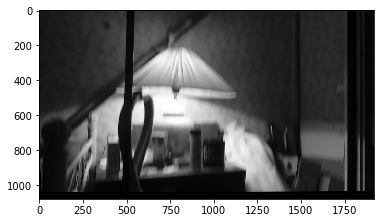

In [8]:
new_im = cv2.warpPerspective(frame1, M, (frame1.shape[1], frame1.shape[0]))
plt.imshow(new_im, cmap='gray')
plt.show()

357


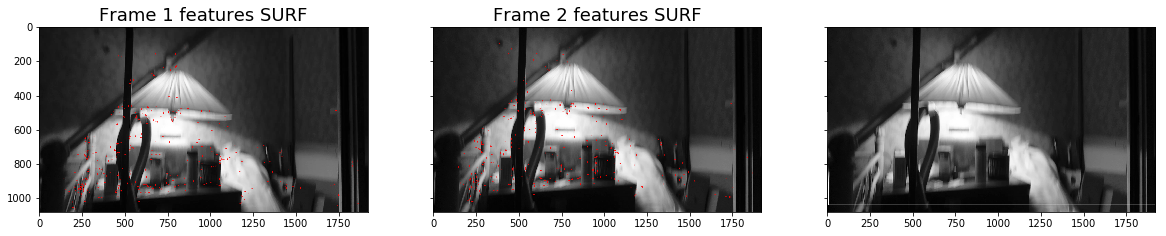

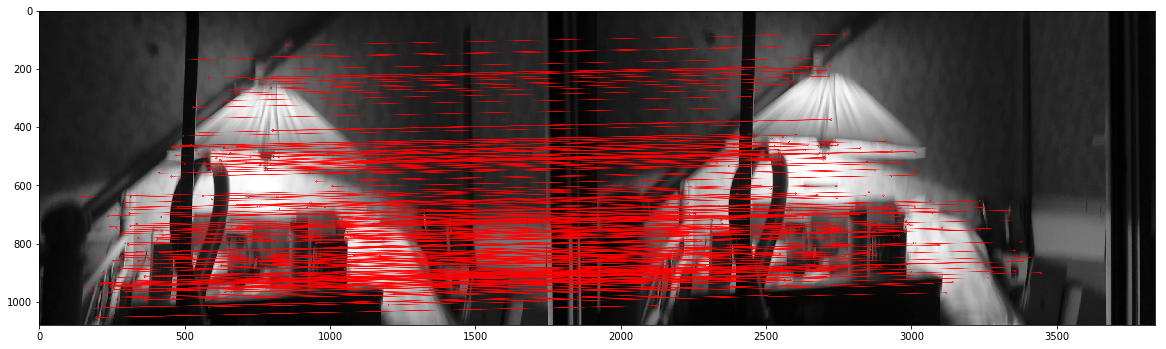

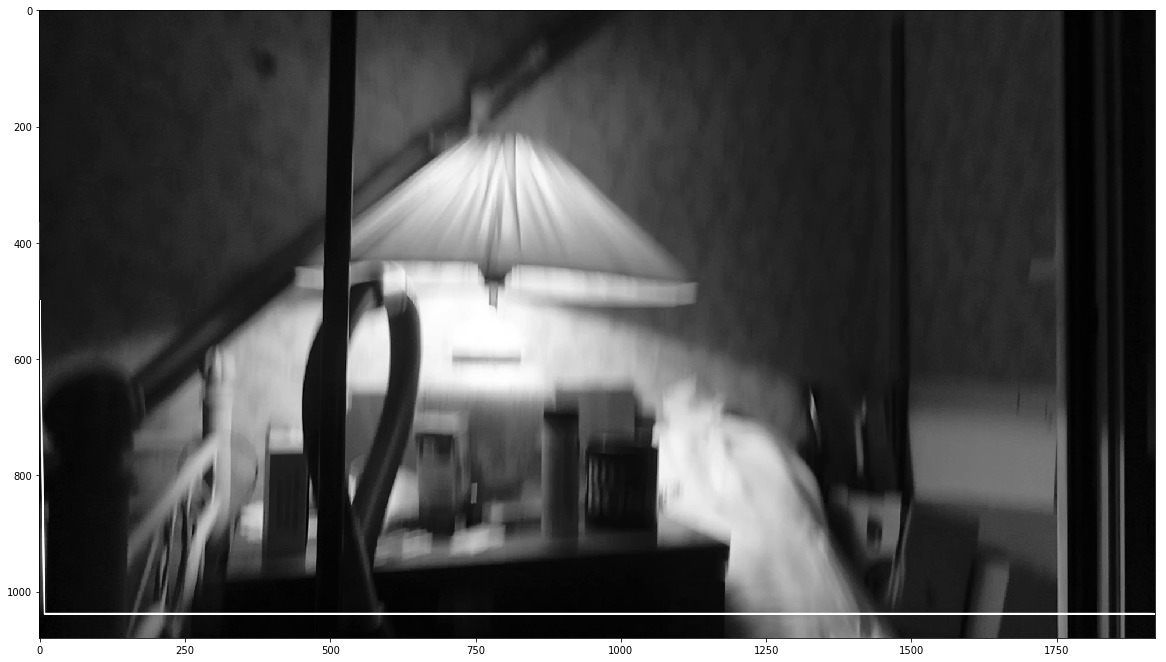

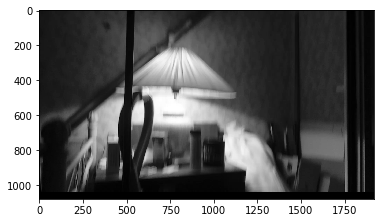

In [9]:
# detecting SURF
name = "vid2.mp4"

cap = cv2.VideoCapture(name)

_, frame1 = cap.read()
_, frame2 = cap.read()

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)


surf = cv2.xfeatures2d.SURF_create(400)
key_points1, descriptors1 = surf.detectAndCompute(frame1, None)
key_points2, descriptors2 = surf.detectAndCompute(frame2, None)

features_1_show = frame1.copy()
features_2_show = frame2.copy()

features_1_show = cv2.drawKeypoints(frame1, key_points1, None, color=(255,0,0))
features_2_show = cv2.drawKeypoints(frame2, key_points2, None, color=(255,0,0))


f, (ax1, ax2, ax4) = plt.subplots(1, 3, sharey=True)
f.set_size_inches(20, 40)
ax1.imshow(features_1_show, cmap='gray')
ax1.set_title("Frame 1 features SURF", fontsize=18)
ax2.imshow(features_2_show, cmap='gray')
ax2.set_title("Frame 2 features SURF", fontsize=18)

# FLANN parameters
# FLANN stands for Fast Library for Approximate Nearest Neighbors. 
# It contains a collection of algorithms optimized for fast nearest neighbor 
# search in large datasets and for high dimensional features.

# number of algorithm with kdtrees
FLANN_INDEX_KDTREE = 0

# passing parameters algorithm and number of trees.
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

# flann based matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# store all the good matches as per Lowe's ratio test.
# We reject all matches in which the
# distance ratio is greater than 0.8, which eliminates 90% of the false matches while discarding
# less than 5% of the correct matches.
good = []
for i, (m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)

print(len(good))

# Getting matched keypoint's location
src_pts = np.float32([ key_points1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
# Getting matched keypoint's location in current frame
dst_pts = np.float32([ key_points2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()

h, w = frame1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts, M)


draw_params = dict(matchColor = (255, 0, 0), # draw matches in green color
                   singlePointColor = (0, 0, 255),
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(frame1, key_points1, frame2, key_points2, good, None, **draw_params)
img4 = cv2.polylines(frame2,[np.int32(dst)], False, 255, 2, cv2.LINE_AA)


#ax3.imshow(img3, cmap='gray')
ax4.imshow(img4, cmap='gray')
plt.show()
f, ax1 =plt.subplots(1, 1, sharey=True)
f.set_size_inches(20, 40)
ax1.imshow(img3, cmap='gray')
plt.show()
plt.figure(figsize=(20, 40))
plt.imshow(img4, cmap='gray')
plt.show()

new_im = cv2.warpPerspective(frame1, M, (frame1.shape[1], frame1.shape[0]))
plt.imshow(new_im, cmap='gray')
plt.show()

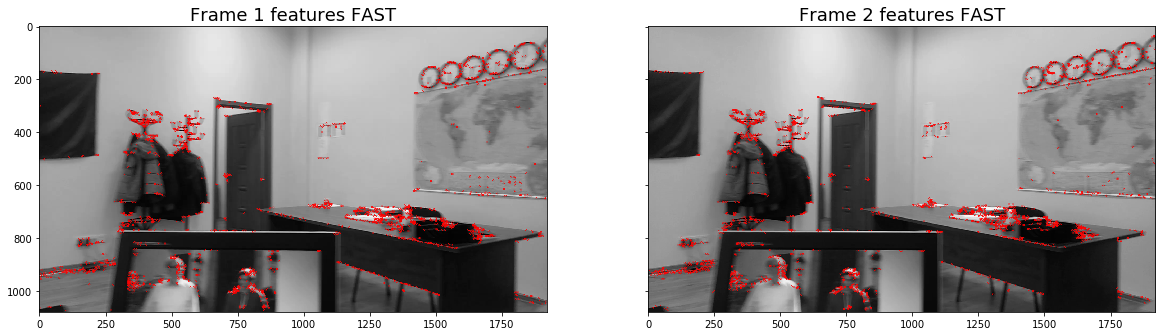

In [30]:
# detecting FAST

fast = cv2.FastFeatureDetector_create()
key_points1 = fast.detect(frame1, None)
key_points2 = fast.detect(frame2, None)

features_1_show = frame1.copy()
features_2_show = frame2.copy()

features_1_show = cv2.drawKeypoints(frame1, key_points1, None, color=(255, 0, 0))
features_2_show = cv2.drawKeypoints(frame2, key_points2, None, color=(255, 0, 0))


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(20, 40)
ax1.imshow(features_1_show, cmap='gray')
ax1.set_title("Frame 1 features FAST", fontsize=18)
ax2.imshow(features_2_show, cmap='gray')
ax2.set_title("Frame 2 features FAST", fontsize=18)
plt.show()